## Overview 

In this example, a convolutional neural network (CNN) model will be trained to identify 16 types of electrical signals common in the field of electrical power distribution by analyzing the signal that contains noise and identifying the pattern of the main signal.

The 16 Type of Signals : 

1. Flicker
2. Flicker+Harmonics
3. Flicker+Sag
4. Flicker+Swell
5. Harmonics
6. Impulsive Transient
7. Interruption
8. Interruption+Harmonics
9. Normal
10. Notch
11. Oscillatory transient
12. Sag
13. Sag+Harmonics
14. Spike
15. Swell
16. Swell+Harmonics

## Required Libraries 

In [1]:
import numpy as np
import scipy as sp 

from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization


from keras.utils.np_utils import to_categorical
from keras import regularizers

from DeepCNN_Functions import scheduler

# 1. Importing and checking the Dataset

In [2]:
from scipy.io import loadmat 
DataBase = loadmat('16PQDs_480_NoNoise.mat')
X = []
Y = []

In [3]:
L = DataBase['SignalsDataBase'].size
for i in range (0,L-1): 

    X.append(DataBase ['SignalsDataBase'][0][i]['signals'][0])
    Y.append(DataBase ['SignalsDataBase'][0][i]['labels'][0])

X = np.asarray(X).astype('float32')

In [4]:
print("X Shape: ", X.shape)
print("Length Y : " , len(Y))

X Shape:  (7679, 640)
Length Y :  7679


In [5]:
Tr = int(len(Y)*0.80)
X_train = np.array(X[0:Tr]) #80 % of data Training

X_train = np.expand_dims(X_train,axis=-1)
numOfFeatures = X_train.shape[1]

Y_train = np.reshape(np.array(Y[0:Tr]) , (Tr,1) )
X_validate = np.array(X[Tr:len(X)])

X_validate = np.expand_dims(X_validate,axis=-1)

Y_validate =  np.reshape( np.array(Y[Tr:len(Y)]) ,(len(Y)-Tr,1) )

In [6]:
print("Xtrain Shape : ", X_train.shape)
print("Ytrain Shape : ", Y_train.shape)

Xtrain Shape :  (6143, 640, 1)
Ytrain Shape :  (6143, 1)


### Data Example : 

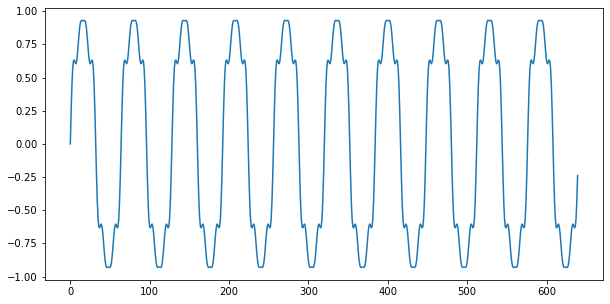

In [13]:
Ex = X_train[0]
fig = plt.figure(figsize=(10,5))
plt.plot(Ex)

# 2. Normalize the data and Onehot encoding

In [7]:
# Make OneHot classes :

from sklearn.preprocessing import OneHotEncoder#,LabelEncoder
OHE = OneHotEncoder()
#y_test_OneHot = OHE.fit_transform(y_test).toarray()
Y_train_OneHot = OHE.fit_transform(Y_train).toarray()
Y_validate_OneHot = OHE.fit_transform(Y_validate).toarray()

# 3.  Convolutional Neural Network Model Building and Training


In [8]:
# Defining the CNN model :

model = keras.models.Sequential()

#add model layers:
'''======================================== UNIT_1 ======================================'''
# Conv1:Model Unites and Layers
model.add(keras.layers.Conv1D(filters = 32, kernel_size=3,strides = 1, activation='relu', input_shape=(numOfFeatures,1)))
# Conv2:
model.add(keras.layers.Conv1D(filters = 32, kernel_size=3,strides = 1, activation='relu'))
# Pool1:
model.add(keras.layers.MaxPool1D(pool_size=(3), strides = 1))
# BN1:
model.add(keras.layers.BatchNormalization())
'''========================================= UNIT_2 ====================================='''
# Conv3:
model.add(keras.layers.Conv1D(filters = 64, kernel_size=3,strides = 1, activation='relu'))
# Conv4:
model.add(keras.layers.Conv1D(filters = 64, kernel_size=3,strides = 1, activation='relu'))
# Pool2:
model.add(keras.layers.MaxPool1D(pool_size=(3), strides = 1))
# BN2:
model.add(keras.layers.BatchNormalization())
'''========================================= UNIT_3 ====================================='''
# Conv5:
model.add(keras.layers.Conv1D(filters = 128, kernel_size=3,strides = 1, activation='relu'))
# Conv6:
model.add(keras.layers.Conv1D(filters = 128, kernel_size=3,strides = 1, activation='relu'))
# Pool3:
model.add(keras.layers.GlobalMaxPooling1D()) #TODO : data_format='channels_first' ??
# BN4:
model.add(keras.layers.BatchNormalization())

'''================================== Fuuly Connected Part =============================='''

model.add(tf.keras.layers.Flatten()) 
# Dense1:
model.add(keras.layers.Dense(units=256, activation='relu',use_bias=True))
# Dense2:
model.add(keras.layers.Dense(units=128, activation='relu',use_bias=True))
# BN3:
model.add(keras.layers.BatchNormalization())
# Dense3:
model.add(keras.layers.Dense(units=16, activation='softmax',use_bias=True))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 638, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 636, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 634, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 634, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, 632, 64)           6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 630, 64)           1

In [28]:
# training parameters:

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
          
model.compile(  loss        = 'categorical_crossentropy',
                optimizer   = 'nadam',
                metrics     = ['accuracy']   
             )
                

model_history = model.fit(X_train, Y_train_OneHot, 
                        batch_size = 64,
                        epochs=40 , 
                        callbacks=[callback],
                        validation_data=(X_validate, Y_validate_OneHot),
                        verbose=1)


Train on 59999 samples, validate on 16801 samples
lr = 0.01
Epoch 1/40
59999/59999 [==============================] - 278s 5ms/sample - loss: 0.3569 - accuracy: 0.8531 - val_loss: 5.5501 - val_accuracy: 0.3446
lr = 0.01
Epoch 2/40
59999/59999 [==============================] - 261s 4ms/sample - loss: 0.2640 - accuracy: 0.8887 - val_loss: 2.5146 - val_accuracy: 0.5375
lr = 0.01
Epoch 3/40
59999/59999 [==============================] - 259s 4ms/sample - loss: 0.1837 - accuracy: 0.9248 - val_loss: 2.4112 - val_accuracy: 0.5577
lr = 0.01
Epoch 4/40
59999/59999 [==============================] - 255s 4ms/sample - loss: 0.1490 - accuracy: 0.9416 - val_loss: 1.3902 - val_accuracy: 0.6273
lr = 0.01
Epoch 5/40
59999/59999 [==============================] - 255s 4ms/sample - loss: 0.1349 - accuracy: 0.9475 - val_loss: 2.5480 - val_accuracy: 0.6060
lr = 0.01
Epoch 6/40
59999/59999 [==============================] - 255s 4ms/sample - loss: 0.1246 - accuracy: 0.9526 - val_loss: 1.5357 - val_accurac

## 4. CNN accuracy Plot 

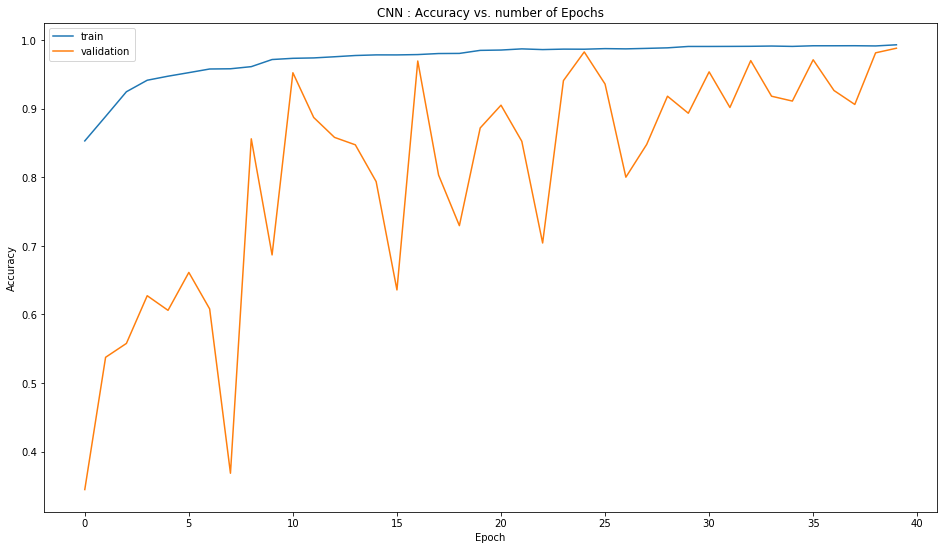

In [29]:
# Plot CNN's accuracy vs. epoch num:
fig = plt.figure(figsize=(16,9))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN : Accuracy vs. number of Epochs')
plt.legend(['train','validation'])
plt.show()

### After the stage of training and testing the model, it appears in the previous figure that the accuracy rate of the model reached approximately 99% after analyzing the data in 40 different arrangements 

In [35]:
Accuracy_final = model_history.history['accuracy']
print("the average Accuracy : ",sum(Accuracy_final)/len(Accuracy_final))
print("Last Epoch's Accuracy : ", Accuracy_final[-1] )

the average Accuracy :  0.9733199685811996
Last Epoch's Accuracy :  0.9932666


In [36]:
# Model saving : 
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("16_Cnn_withNoise.h5")
print("Model has been saved to the disk ! ")

Model has been saved to the disk ! 
